<a href="https://colab.research.google.com/github/bdunn20/book_code/blob/main/football_analytics/Ch_7_Web_Scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7 - Web Scraping
## Obtaining & Analyzing Draft Picks

### Packages

In [ ]:
! pip install nfl_data_py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=27d5afaad05972bf32b609b50c984f48e5ca1017f9504dfd98de9eda2b7b7efe
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [ ]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

### Get Data

In [ ]:
# scraping 2022 draft data
url = "https://www.pro-football-reference.com/years/2022/draft.htm"

draft = pd.read_html(url, header=1)[0]
draft.loc[draft["DrAV"].isnull(), "DrAV"] = 0
print(draft)

    Rnd Pick   Tm              Player Pos Age    To AP1 PB St  ... Yds.1 TD.1  \
0     1    1  JAX       Travon Walker  DE  21  2023   0  0  1  ...     0    0   
1     1    2  DET    Aidan Hutchinson  DE  22  2023   0  0  1  ...     0    0   
2     1    3  HOU  Derek Stingley Jr.  CB  21  2023   0  0  1  ...     0    0   
3     1    4  NYJ       Sauce Gardner  CB  22  2023   1  1  1  ...     0    0   
4     1    5  NYG   Kayvon Thibodeaux  DE  21  2023   0  0  1  ...     0    0   
..   ..  ...  ...                 ...  ..  ..   ...  .. .. ..  ...   ...  ...   
263   7  258  GNB        Samori Toure  WR  24  2023   0  0  0  ...     0    0   
264   7  259  KAN      Nazeeh Johnson   S  24  2022   0  0  0  ...     0    0   
265   7  260  LAC      Zander Horvath  RB  23  2022   0  0  0  ...     8    0   
266   7  261  LAR           AJ Arcuri  OT  25  2022   0  0  0  ...     0    0   
267   7  262  SFO         Brock Purdy  QB  22  2023   0  0  0  ...   157    3   

    Rec Yds.2 TD.2 Solo Int

In [ ]:
# scraping multiple years of draft data
draft = pd.DataFrame()
for i in range(2000, 2023 + 1):
  url = "https://www.pro-football-reference.com/years/" + str(i) + "/draft.htm"
  web_data = pd.read_html(url, header=1)[0]
  web_data["Season"] = i
  # save only rows whose value is not equal to the column's name
  web_data = web_data.query('Tm != "Tm"')
  draft = pd.concat([draft, web_data])

draft.reset_index(drop=True, inplace=True)

In [ ]:
# clean data for teams who have multiple values due to relocation
# Chargers, Raiders and Rams
# using np.select()
conditions = [(draft.Tm == "SDG"), (draft.Tm == "OAK"), (draft.Tm == "STL")]
choices = ["LAC", "LVR", "LAR"]

draft["Tm"] = np.select(conditions, choices, default=draft.Tm)

# replace missing draft approximate values with zero before resetting the index
# save the file
draft.loc[draft["DrAV"].isnull(), "DrAV"] = 0
draft.to_csv("data.csv", index=False)

print(draft.head())

  Rnd Pick   Tm           Player Pos Age    To AP1 PB St  ... TD.1  Rec Yds.2  \
0   1    1  CLE   Courtney Brown  DE  22  2005   0  0  4  ...    0    0     0   
1   1    2  WAS  LaVar Arrington  LB  22  2006   0  3  5  ...    0    0     0   
2   1    3  WAS    Chris Samuels   T  23  2009   0  6  9  ...    0    0     0   
3   1    4  CIN    Peter Warrick  WR  23  2005   0  0  4  ...    2  275  2991   
4   1    5  BAL      Jamal Lewis  RB  21  2009   1  1  9  ...   58  221  1879   

  TD.2 Solo Int.1    Sk College/Univ    Unnamed: 28 Season  
0    0  156   NaN  19.0     Penn St.  College Stats   2000  
1    0  338     3  23.5     Penn St.  College Stats   2000  
2    0  NaN   NaN   NaN      Alabama  College Stats   2000  
3   18    3   NaN   NaN  Florida St.  College Stats   2000  
4    4  NaN   NaN   NaN    Tennessee  College Stats   2000  

[5 rows x 30 columns]


In [ ]:
# look at columns available
print(draft.columns)

Index(['Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'Age', 'To', 'AP1', 'PB', 'St',
       'wAV', 'DrAV', 'G', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Att.1', 'Yds.1',
       'TD.1', 'Rec', 'Yds.2', 'TD.2', 'Solo', 'Int.1', 'Sk', 'College/Univ',
       'Unnamed: 28', 'Season'],
      dtype='object')


In [ ]:
# select usable columns from the data & order columns
draft_use = draft[["Season", "Pick", "Tm", "Player", "Pos", "wAV", "DrAV"]]
print(draft_use)

      Season Pick   Tm              Player Pos  wAV DrAV
0       2000    1  CLE      Courtney Brown  DE   27   21
1       2000    2  WAS     LaVar Arrington  LB   46   45
2       2000    3  WAS       Chris Samuels   T   63   63
3       2000    4  CIN       Peter Warrick  WR   27   25
4       2000    5  BAL         Jamal Lewis  RB   69   53
...      ...  ...  ...                 ...  ..  ...  ...
6125    2023  255  SFO        Jalen Graham   S    0    0
6126    2023  256  GNB        Grant Dubose  WR  NaN    0
6127    2023  257  DEN        Alex Forsyth  OL  NaN    0
6128    2023  258  CHI  Kendall Williamson   S  NaN    0
6129    2023  259  LAR     Desjuan Johnson  DT    0    0

[6130 rows x 7 columns]


Data dictionary for our dataset:
- Season
  - The season in which the player was drafted
- Pick
  - Which selection number they were taken at
- Tm
  - The drafting team
- Player
  - Player's Name
- Pos
  - Player's Position
- wAv
  - Player's whole career approximate value
- DrAV
  - Player's approximate value for the drafting team

In [ ]:
# save data file
draft_use.to_csv("draft_use.csv", index=False)

### Approximate Value generated by each player for his drafting team

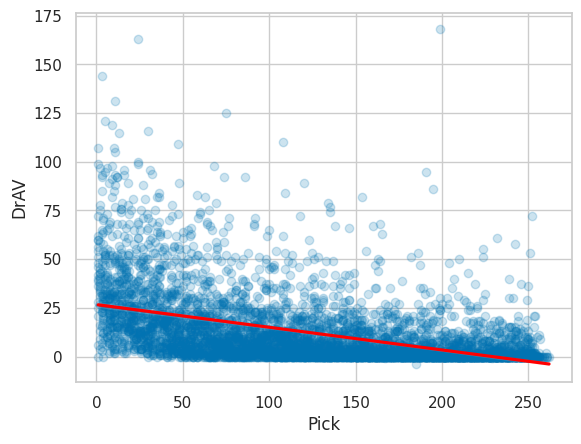

In [ ]:
# filter to years prior to 2020 (player who have fulfilled all of draft contract)
sns.set_theme(style="whitegrid", palette="colorblind")
draft_use_pre2019 = draft_use.query("Season <= 2019")

# format columns as numeric
draft_use_pre2019 = draft_use_pre2019.astype({"Pick": int, "DrAV": float})

sns.regplot(data=draft_use_pre2019, x="Pick", y="DrAV", line_kws={"color": "red"},
            scatter_kws={'alpha':0.2})
plt.show()

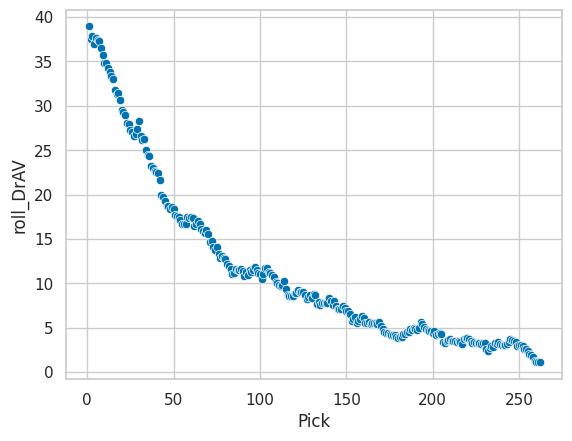

In [ ]:
# calc the avgvalue for each pick
draft_chart_py = draft_use_pre2019.groupby(["Pick"]).agg({"DrAV":["mean"]})

draft_chart_py.columns = list(map("_".join, draft_chart_py.columns))

draft_chart_py.loc[draft_chart_py.DrAV_mean.isnull()] = 0

draft_chart_py["roll_DrAV"] = (draft_chart_py["DrAV_mean"].rolling(window=13, min_periods=1, center=True).mean())

sns.scatterplot(draft_chart_py, x="Pick", y="roll_DrAV")
plt.show()

In [ ]:
# drop the index (so you can access Pick with the model) and then plot
draft_chart_py.reset_index(inplace=True)

draft_chart_py["roll_DrAV_log"] = np.log(draft_chart_py["roll_DrAV"] + 1)

DrAV_pick_fit_py = smf.ols(formula="roll_DrAV_log ~ Pick", data=draft_chart_py).fit()

print(DrAV_pick_fit_py.summary())

                            OLS Regression Results                            
Dep. Variable:          roll_DrAV_log   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     8617.
Date:                Wed, 03 Jan 2024   Prob (F-statistic):          2.35e-201
Time:                        21:09:31   Log-Likelihood:                 178.42
No. Observations:                 262   AIC:                            -352.8
Df Residuals:                     260   BIC:                            -345.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4884      0.015    228.993      0.0

In [ ]:
# merge back into draft_chart_py
draft_chart_py["fitted_DrAV"] = np.exp(DrAV_pick_fit_py.predict()) - 1
# view top of the data
draft_chart_py.head()

,Pick,DrAV_mean,roll_DrAV,roll_DrAV_log,fitted_DrAV
0,1,47.60,38.950000,3.687629,31.428778
1,2,39.85,37.575000,3.652604,31.127886
2,3,44.45,37.883333,3.660566,30.829785
3,4,31.15,36.990000,3.637323,30.534451
4,5,43.65,37.627273,3.653959,30.241856


### Evaluating the 2018 Jets/Colts Trade

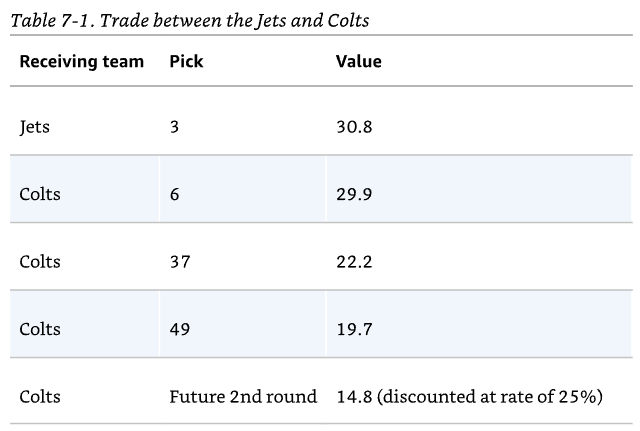

### Are some teams better at drafting players than others?

In [ ]:
# adjust expectations for each pick using the previously created model
# take the avg and std deviation of the diff b/t DrAV and fitted_DrAV
# aggregate over the 2000-19 drafts

draft_use_pre2019 = draft_use_pre2019.merge(draft_chart_py[["Pick", "fitted_DrAV"]],
                                                  on="Pick")

draft_use_pre2019["OE"] = (draft_use_pre2019["DrAV"] - draft_use_pre2019["fitted_DrAV"])

draft_use_pre2019.groupby("Tm").agg({"OE": ["count", "mean", "std"]})\
                                  .reset_index().sort_values([("OE", "mean")],\
                                  ascending=False)

Tm    OE                     
        count      mean        std
26  PIT   161  3.525774  18.873699
11  GNB   180  3.373462  20.062605
8   DAL   160  2.462862  16.616522
1   ATL   148  2.292682  16.120177
21  NOR   131  2.286153  18.124209
22  NWE   176  2.164410  20.821272
13  IND   162  1.854290  15.755905
4   CAR   148  1.842769  16.505365
2   BAL   170  1.723823  16.890186
27  SEA   181  1.483275  16.949394
16  LAC   144  1.392633  14.606559
5   CHI   149  0.672768  16.051511
20  MIN   167  0.545602  13.983751
15  KAN   154  0.502626  15.016540
25  PHI   162  0.473891  15.350440
6   CIN   176  0.466698  15.812246
14  JAX   158  0.182425  13.112373
30  TEN   172  0.129590  12.662011
12  HOU   145 -0.075422  12.974443
28  SFO   184 -0.091457  13.449032
31  WAS   150 -0.449148   9.949274
24  NYJ   138 -0.551394  13.268448
0   ARI   149 -0.602462  14.294614
29  TAM   153 -0.921525  11.408413
3   BUF   161 -0.985990  12.459061
23  NYG   144 -0.999662  12.432342
17  LAR   175 -1.438906  11.983605
19  MIA   151 -1.485328  10.472036
9   DEN   159 -1.491445  12.593647
10  DET   155 -1.767026  12.060276
18  LVR   162 -2.587472  10.219390
7   CLE   170 -3.558657  10.337918

In [ ]:
# compute std error for each team

draft_use_pre2019 = draft_use_pre2019.merge(draft_chart_py[["Pick", "fitted_DrAV"]], on="Pick")

draft_use_pre2019_tm = draft_use_pre2019.groupby("Tm").agg({"OE": ["count", "mean", "std"]})\
                        .reset_index().sort_values([("OE", "mean")], ascending=False)

draft_use_pre2019_tm.columns = list(map("_".join, draft_use_pre2019_tm.columns))

draft_use_pre2019_tm.reset_index(inplace=True)

draft_use_pre2019_tm["se"] = (
    draft_use_pre2019_tm["OE_std"] / np.sqrt(draft_use_pre2019_tm["OE_count"])
)

draft_use_pre2019_tm["lower_bound"] = draft_use_pre2019_tm["OE_mean"] - 1.96 * draft_use_pre2019_tm["se"]

draft_use_pre2019_tm["upper_bound"] = draft_use_pre2019_tm["OE_mean"] + 1.96 * draft_use_pre2019_tm["se"]

print(draft_use_pre2019_tm)

    index  Tm_  OE_count   OE_mean     OE_std        se  lower_bound  \
0      26  PIT       161  3.525774  18.873699  1.487456     0.610361   
1      11  GNB       180  3.373462  20.062605  1.495378     0.442520   
2       8  DAL       160  2.462862  16.616522  1.313651    -0.111895   
3       1  ATL       148  2.292682  16.120177  1.325070    -0.304456   
4      21  NOR       131  2.286153  18.124209  1.583520    -0.817545   
5      22  NWE       176  2.164410  20.821272  1.569462    -0.911736   
6      13  IND       162  1.854290  15.755905  1.237901    -0.571996   
7       4  CAR       148  1.842769  16.505365  1.356733    -0.816427   
8       2  BAL       170  1.723823  16.890186  1.295418    -0.815196   
9      27  SEA       181  1.483275  16.949394  1.259839    -0.986008   
10     16  LAC       144  1.392633  14.606559  1.217213    -0.993105   
11      5  CHI       149  0.672768  16.051511  1.314991    -1.904615   
12     20  MIN       167  0.545602  13.983751  1.082095    -1.57

Only the Packers & Steelers are statistically significantly better than other teams. While only the Raiders & Browns are worse.